# Data Science and Health final project

## Overview and Background

The rise of machine learning and data science have allowed for significant innovation within many fields--particularly in healthcare, where there is a high potential for impact through life-saving solutions and increased hospital efficiencies. The underlying concept is to utilize previous patient experiences (and the associated data) to make predictions that could both improve conditions for future patients, increase efficiency for overbooked physicians, and greatly reduce healthcare costs. The ultimate goal in this work was to develop an algorithm that utilizes the MIMIC-III database to predict the likelihood of patient readmission within 30 days of hospital discharge. The MIMIC-III database is a collection of patient data from intensive care unit hospital stays.

This sort of algorithm implemented in a hospital setting has great potential to improve outcomes for patients, assist physicians, and reduce healthcare costs. Particularly, hospital readmissions are a large source of healthcare costs and identifying patients that are of higher risk of readmission would lead to greater care prior to their initial discharge. Specifically, if a patient is readmitted within 30 days, it is likely that they were not healthy enough to leave the hospital at the time of discharge. In order to prevent this occurrence, there are financial penalties to incentivize hospitals to only discharge patients when they are stable enough to be discharged. Therefore, an algorithm that identifies patients who are at higher risk for a 30 day readmission would be hugely beneficial to the doctors caring for those patients. The doctors would then be able to exercise extreme caution when discharging these patients, ensuring they are in a stable enough condition to leave care. This extra caution would benefit doctors, hospitals, and most importantly the health of patients.

## Data

## Exploratory Data Analysis

## Modeling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt
import sqlite3

### Getting Tables

In [2]:
# CREATE CONNECTION TO ON-DISK DATABASE

# This database contains a table with a subset of patients.
# The majority class is downsampled so that the classes are balanced.
conn = sqlite3.connect("./data/labevents_balanced.db") 

# This database contains a table that links ITEMID to LABEL
conn2 = sqlite3.connect("./data/lab_events.db")

### Create Dataframes

In [3]:
# Contains lab measurements for patient subset
lab_events_df = pd.read_sql("""SELECT * FROM labevents""", conn)

# Links ITEMID to LABEL
lab_items_df = pd.read_sql("""SELECT * FROM lab_items""", conn2)

# Convert to numeric data types
lab_events_df["SUBJECT_ID"] = pd.to_numeric(lab_events_df["SUBJECT_ID"])
lab_events_df["HADM_ID"] = pd.to_numeric(lab_events_df["HADM_ID"]).astype(int)
lab_events_df["VALUENUM"] = pd.to_numeric(lab_events_df["VALUENUM"])

# Merge with labels for laboratory measurements
lab_events_df = lab_events_df.merge(lab_items_df[['ITEMID','LABEL']], left_on='ITEMID', right_on='ITEMID')

lab_events_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,LABEL
0,12019,30,104557,50800,2172-10-14 16:06:00,ART,NaN,,,SPECIMEN TYPE
1,34727,71,111944,50800,2164-02-03 21:07:00,ART,NaN,,,SPECIMEN TYPE
2,34766,71,111944,50800,2164-02-03 23:14:00,ART,NaN,,,SPECIMEN TYPE
3,34772,71,111944,50800,2164-02-04 02:30:00,ART,NaN,,,SPECIMEN TYPE
4,32967,68,170467,50800,2173-12-15 12:39:00,ART,NaN,,,SPECIMEN TYPE


### Truth Labels

In [4]:
# Here, we extract the truth labels. A label of 1 indicates that a patient was
# readmitted within 30 days, and a label of 0 indicates otherwise.

# Load in information about truth labels and corresponding admissions
# Column 1: SUBJECT_ID
# Column 2: TRUTH
# Column 3: HADM_ID
truth_array = np.loadtxt("csv/TRUTH.csv", delimiter=',', skiprows=1)

# Create a dataframe with truth labels
truth_df = pd.DataFrame(truth_array, columns=['SUBJECT_ID', 'TRUTH', 'HADM_ID'])

# Convert to ints
truth_df["SUBJECT_ID"] = truth_df["SUBJECT_ID"].astype(int)
truth_df["TRUTH"] = truth_df["TRUTH"].astype(int)
truth_df["HADM_ID"] = truth_df["HADM_ID"].astype(int)

### Relevant Admissions

In [5]:
# Only interested in lab events corresponding to the relevant admissions, i.e. those where
# patient did not die during the first visit
relevant_lab_events_df = lab_events_df.merge(truth_df, on='HADM_ID')

# Get relevant truth labels
hadm_df = pd.DataFrame(lab_events_df["HADM_ID"].unique(), columns={'HADM_ID'})

# Get updated truth_df
relevant_truth_df = hadm_df.merge(truth_df, how='inner', on='HADM_ID')

### Extract Features

Here, we extract features from the laboratory measurements. For all lab tests, we calculate the proportion of measurements that were flagged as abnormal. The rationale behind this approach is that a higher proportion of abnormal measurements may indicate that the patient is sicker, making it more likely that they will be readmitted within 30 days. This step resulted in a set of 499 features.

In [6]:
# Create binary variable to represent whether measurement is abnormal
relevant_lab_events_df['ABNORMAL'] = 0
relevant_lab_events_df.loc[relevant_lab_events_df['FLAG']=='abnormal', 'ABNORMAL'] = 1

# Get proportion of measurements that are abnormal
abnormal_df = relevant_lab_events_df.groupby(['HADM_ID', 'ITEMID'], as_index = False)['ABNORMAL'].mean()

# Get list of measurement names
meas_type = np.unique(lab_events_df["ITEMID"].get_values())

# Initially set design matrix equal to truth dataframe
design_mat_df = relevant_truth_df

# For all measurement types, get the proportion of abnormal values
for meas in meas_type:
    # Get proportion of abnormal values
    curr_df = abnormal_df.loc[abnormal_df["ITEMID"] == meas, ["HADM_ID", "ABNORMAL"]]
    
    # Rename
    rename_as = meas + "_ABNORMAL"
    curr_df = curr_df.rename(index=str, columns={"ABNORMAL": rename_as})
    
    # Merge
    design_mat_df = design_mat_df.merge(curr_df, how='left', on='HADM_ID')
    
# Get X and y values
X = design_mat_df.iloc[:, 3:len(design_mat_df.columns)].get_values()
y = design_mat_df.TRUTH.get_values()

### Select Features

In this section, we describe a technique to reduce the number of features in the data. The reason for selecting only a subset of features is to avoid the curse of dimensionality, which asserts that the hypervolume increases much faster than observations can fill the space. If the number of features is large compared to the number of observations, a classifier trained on the data will tend to overfit the training set. An additional challenge associated with this dataset is that different types of lab tests are performed on different patients, resulting in a substantial number of missing values. This exacerbates the data sparsity problem associated with high dimensional data. To mitigate this concern, we select features that have at least 50 percent non-missing values in the training set. 

In [7]:
from sklearn.model_selection import train_test_split

# make train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.33, random_state = 0)

# Select features that have at least 50% non-missing values in the training set
prop_non_missing = (~np.isnan(X_train)).sum(0)/len(X_train)
threshold = 0.5

# Select same features in training and testing set
X_train = X_train[:, prop_non_missing > threshold]
X_test = X_test[:, prop_non_missing > threshold]

After feature selection, we obtained a set of 56 features describing the proportion of abnormal measurements. The table below lists the lab test and the fluid from which samples were obtained.

In [8]:
# Get names of selected features
all_columns = design_mat_df.iloc[:, 3:len(design_mat_df.columns)].columns
selected_features_df = pd.DataFrame(all_columns[prop_non_missing > threshold], columns={"ITEMID"})

# Strip _ABNORMAL from the name
selected_features_df["ITEMID"] = selected_features_df["ITEMID"].replace(to_replace="_ABNORMAL", value="", regex=True)

# Get labels and fluid from lab_items_df
selected_features_df = selected_features_df.merge(lab_items_df.loc[:,["LABEL", "FLUID", "ITEMID"]], how='inner', on='ITEMID')
selected_features_df

,ITEMID,LABEL,FLUID
0,50802,Base Excess,Blood
1,50804,Calculated Total CO2,Blood
2,50813,Lactate,Blood
3,50818,pCO2,Blood
4,50820,pH,Blood
5,50821,pO2,Blood
6,50822,"Potassium, Whole Blood",Blood
7,50861,Alanine Aminotransferase (ALT),Blood
8,50862,Albumin,Blood
9,50863,Alkaline Phosphatase,Blood


### Deal With Missing Values

After performing feature selection, many of the proportions are missing values because not all lab tests are performed on a patient. We address the problem by adding a set of indicator variables to denote missing values and by imputing the data.

#### Indicator Variables
We add indicator variables because whether a patient has a certain lab measurement done may give clues about their health. The indicator variable is set to 0 if the corresponding feature is non-missing and 1 if the feature is missing. This results in a set of 112 features.

In [9]:
# Here, we include additional features to indicate the presence of any remaining missing values
missing_train = np.isnan(X_train).astype(int)
missing_test = np.isnan(X_test).astype(int)

# Concatenate to existing X matrices
X_train = np.concatenate((X_train, missing_train), axis=1)
X_test = np.concatenate((X_test, missing_test), axis=1)

#### Imputation
Here, we impute the missing values by replacing them with zeros.

In [10]:
# Replace NaN values
X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0

### Visualization

In [11]:
# Visualize in 2D using TSNE
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2)
# X_tsne = tsne.fit_transform(X_train)

# Plot
# plt.scatter(X_tsne[y_train==0, 0], X_tsne[y_train==0, 1])
# plt.scatter(X_tsne[y_train==1, 0], X_tsne[y_train==1, 1])
# plt.show()

### Testing Different Classifiers With Default Parameters

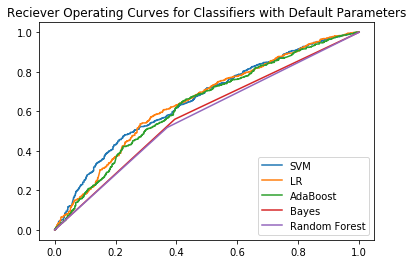

In [19]:
# the following cell runs and evaluates five different classifiers using default parameter values. From this SVM is chosen as the highest performing classifier and continues onto the next section for tuning hyperparameters...

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

def evaluateClass(clf, X_train, y_train, X_test, y_test):
    # this function takes a classifier, training and testing data to obtain a y_pred vector from which you can obtain an AUC metric
    clf = clf.fit(X_train, y_train)
    y_pred = clf.decision_function(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    return AUC, fpr, tpr

# Run SVM classifier
svm = SVC(random_state=42)
svm_AUC, svm_fpr, svm_tpr = evaluateClass(svm, X_train, y_train, X_test, y_test)

# Run LR classifier
LR = LogisticRegression(random_state=0)
LR_AUC, LR_fpr, LR_tpr = evaluateClass(LR, X_train, y_train, X_test, y_test)

# Run Ada classifier
Ada = AdaBoostClassifier()
Ada_AUC, Ada_fpr, Ada_tpr = evaluateClass(Ada, X_train, y_train, X_test, y_test)

# Run Naive Bayes classifier
# Bayes does not have .decision_function() method so cannot be send through evaluateClass() function
Bayes = GaussianNB()
Bayes = Bayes.fit(X_train, y_train)
y_pred = Bayes.predict(X_test)
Bayes_fpr, Bayes_tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
Bayes_AUC = metrics.auc(Bayes_fpr, Bayes_tpr)

# Run the RandomForest classifier
# RandomForest does not have .decision_function() method so cannot be send through evaluateClass() function
RandForest = RandomForestClassifier(random_state=0)
RandForest = RandForest.fit(X_train, y_train)
y_pred = RandForest.predict(X_test)
RandForest_fpr, RandForest_tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
RandForest_AUC = metrics.auc(RandForest_fpr, RandForest_tpr)

# creating dataframe to display results
AUC_Class_df = pd.DataFrame({'Classifier':['SVM','LR','AdaBoost','Bayes','Random Forest'],'AUC':[svm_AUC, LR_AUC, Ada_AUC, Bayes_AUC, RandForest_AUC]})

# Plot ROC curves
import matplotlib.pyplot as plt
plt.figure()
plt.plot(svm_fpr, svm_tpr, label = "SVM")
plt.plot(LR_fpr, LR_tpr, label = "LR")
plt.plot(Ada_fpr, Ada_tpr, label = "AdaBoost")
plt.plot(Bayes_fpr, Bayes_tpr, label = "Bayes")
plt.plot(RandForest_fpr, RandForest_tpr, label = "Random Forest")
plt.legend(loc="lower right")
plt.title("Reciever Operating Curves for Classifiers with Default Parameters")
plt.show()

In [13]:
AUC_Class_df

,Classifier,AUC
0,SVM,0.656237
1,LR,0.648515
2,AdaBoost,0.632528
3,Bayes,0.582694
4,Random Forest,0.574282


From the ROC curves and the AUC values, we can see that SVM performs best. Therefore, in the following section we will focus in on SVM and optimize its parameters.

### Hyperparameter Searching

#### Set up cross-validation

For classification, we will use a support vector machine (SVM). An SVM classifier fits a decision boundary that simultaneously minimizes the error on the training set while maximizing the margin, or the distance between the decision boundary and the nearest point. To allow for non-linear decision boundaries, we use a radial basis function (RBF) kernel, governed by the parameter gamma. We optimize the hyperparameters using 10-fold cross-validation. 

In [14]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

# Set up cross-validation folds
cv = StratifiedKFold(n_splits = 10)

# Number of features
nfeatures = np.shape(X_train)[1]

#### Set up parameter grid

Here, we perform a grid search over different combinations of the cost parameter C and the kernel width gamma. The possible values of C are 0.5, 1.0, 1.5, 2.0, 2.5, and 3.0, and the possible values of gamma are 0.5/D, 1.0/D, 1.5/D, and 2.0/D, where D is the number of features. We select the combination of C and gamma that maximize the area under the roc curve (AUC) averaged across all 10 folds. As shown below, the best feature combination was determined to be C = 1.5 and gamma = 2/D.

In [15]:
# # Parameter grid
# params_grid = {
#     'C': np.arange(0.5, 3.5, 0.5),
#     'gamma': np.arange(0.5/nfeatures, 2.5/nfeatures, 0.5/nfeatures)
# }

# bst_grid = GridSearchCV(estimator = SVC(),
#                        param_grid = params_grid,
#                        cv = cv,
#                        scoring = 'roc_auc')

# bst_grid.fit(X_train, y_train)

# bst_grid.best_params_

#### Classify
Here, we classify the testing data based on the optimized parameters.

In [16]:
# from sklearn.metrics import roc_auc_score

# y_pred = bst_grid.best_estimator_.decision_function(X_test)
# roc_auc_score(y_test, y_pred)

### Classification

In [17]:
# the following cell runs and evaluates four different classifiers using default values. From this SVM is chosen and cross-validated to identify optimized hyper parameters.
svm = SVC(C=1.5, gamma = 0.017857142857142856)
svm = svm.fit(X_train, y_train)
y_pred = svm.decision_function(X_test)

### Evaluation

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
AUC = metrics.auc(fpr, tpr)
print(AUC)

0.6626372296658086


## Suggestions